# CHAPTER 2

## BPE tokenizer

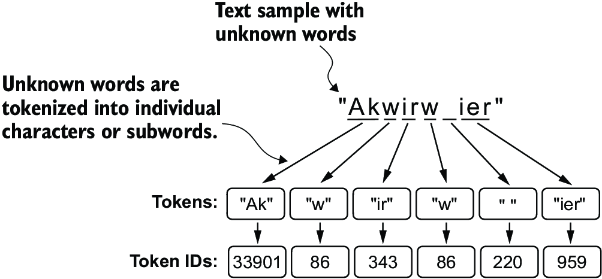

In [11]:
pip install tiktoken

In [12]:
from importlib.metadata import version
import tiktoken
print("tiktoken version: ", version("tiktoken"))

tiktoken version:  0.9.0


In [13]:
BPE_tokenizer = tiktoken.get_encoding("gpt2")
text = "Hello, do you like tea? <|endoftext|> In the sunlit terraces of someunknownPlace."
tokens = BPE_tokenizer.encode(text, allowed_special={"<|endoftext|>"})
print(tokens)



[15496, 11, 466, 345, 588, 8887, 30, 220, 50256, 554, 262, 4252, 18250, 8812, 2114, 286, 617, 34680, 27271, 13]


In [14]:
decode_text = BPE_tokenizer.decode(tokens)
print(decode_text)

Hello, do you like tea? <|endoftext|> In the sunlit terraces of someunknownPlace.


In [15]:
unknow_word = "Akwirw ier"
encode_nums = BPE_tokenizer.encode(unknow_word)
for num in encode_nums:
    print(f"{num}: {BPE_tokenizer.decode([num])}")

33901: Ak
86: w
343: ir
86: w
220:  
959: ier


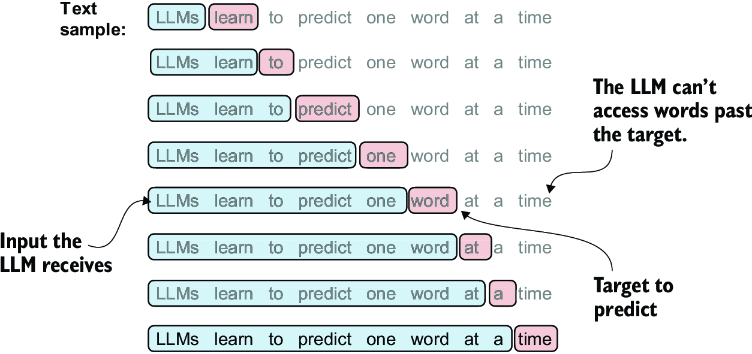
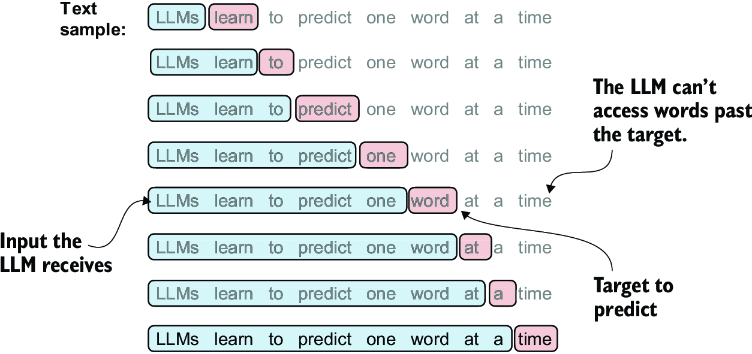

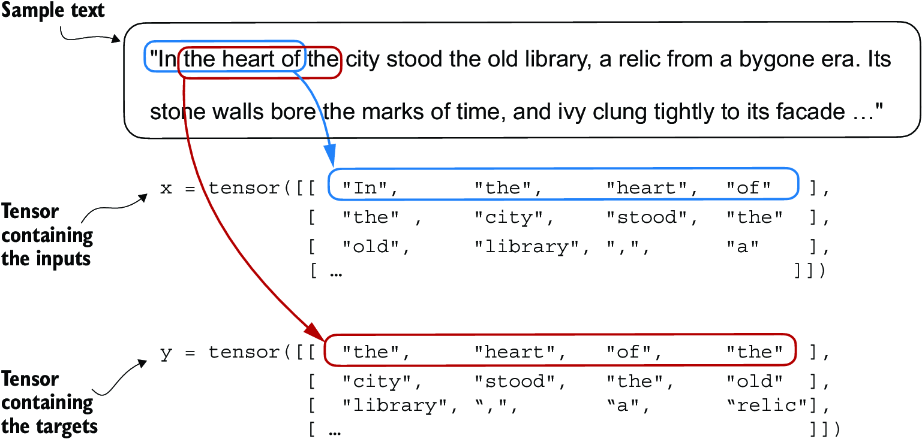
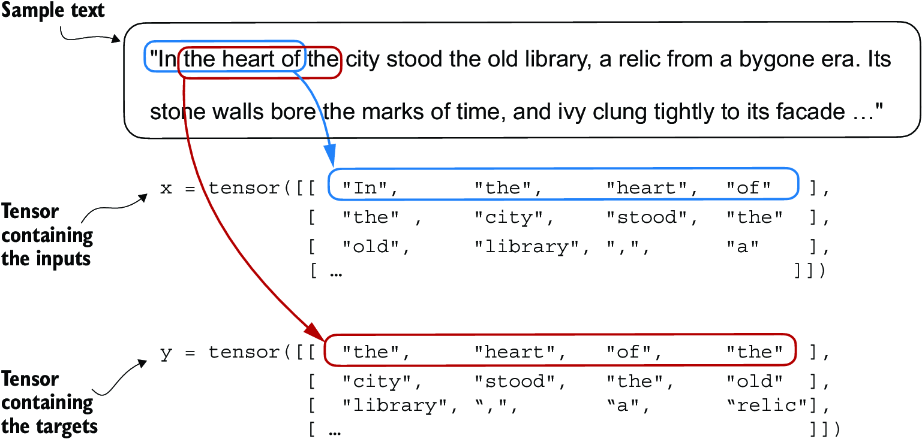

In [16]:
import torch
from torch.utils.data import DataLoader,Dataset


In [17]:
class GPTdatasetV1(Dataset):

    """
    Dataset for GPT-2, Slide Window.
    txt: Input text.
    tokenizer: Tokenizer.
    window_length: Length of the window.
    stride: Stride of the window. (How many words to skip).

    __len__: return size of the input data.
    """

    def __init__(self, txt, tokenizer, window_length, stride):
        self.input_ids = []
        self.output_ids = []

        words_to_nums = tokenizer.encode(txt)

        for i in range(0, len(words_to_nums) - window_length, stride):
            self.input_ids.append(torch.tensor(words_to_nums[i:i+window_length]))
            self.output_ids.append(torch.tensor(words_to_nums[i+1:i+window_length+1]))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.output_ids[idx]


In [18]:
# Customize dataloader

def create_dataloader_v1(txt, batch_size=4, window_length=256, stride=128,shuffle=True, drop_last=True, num_workers=0):
    # define tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # define dataset
    dataset = GPTdatasetV1(txt, tokenizer, window_length, stride)

    # define dataloader
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)

    return dataloader

In [19]:
with open("the-verdict.txt", "r") as fn:
    raw_txt = fn.read()

dataloader = create_dataloader_v1(raw_txt, 1, 4, 1, False)
iter_dataloader = iter(dataloader)
first = next(iter_dataloader)
first

[tensor([[  40,  367, 2885, 1464]]), tensor([[ 367, 2885, 1464, 1807]])]

## Token Embedding

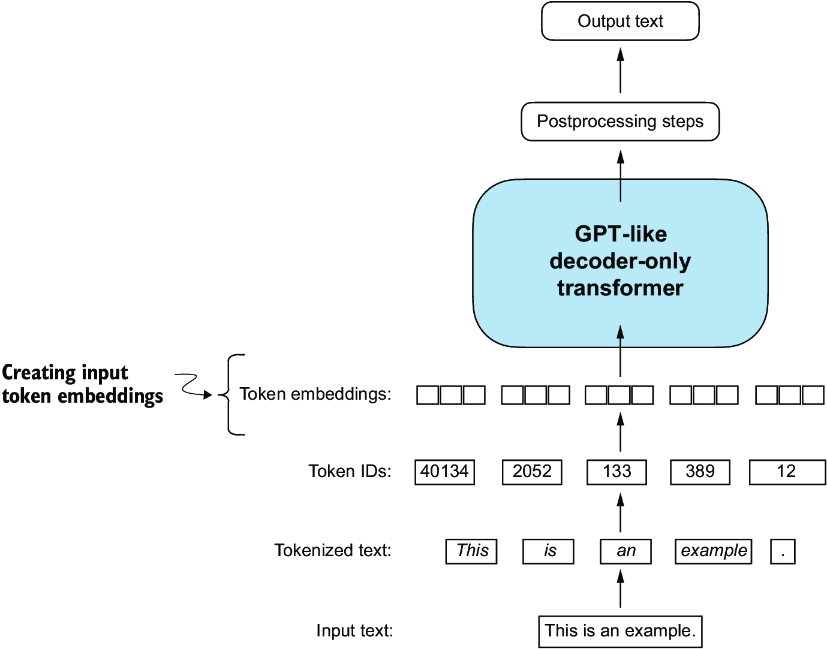

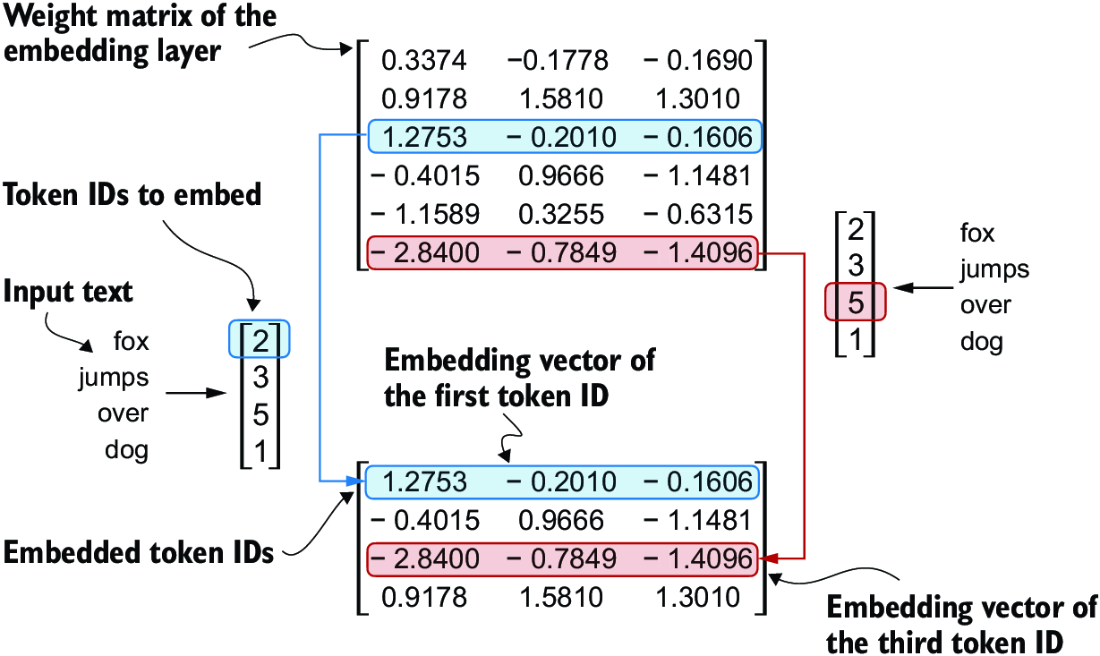

##Encoding word positions

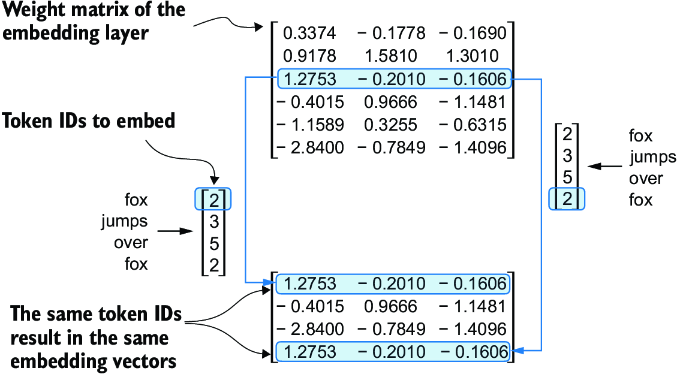

The way the previously introduced embedding layer works is that the same token ID always gets mapped to the same vector representation, regardless of where the token ID is positioned in the input sequence.The embedding layer converts a token ID into the same vector representation regardless of where it is located in the input sequence. For example, the token ID 5, whether it’s in the first or fourth position in the token ID input vector, will result in the same embedding vector.

since the self-attention mechanism of LLMs itself is also position-agnostic, it is helpful to inject additional position information into the LLM.

##Absolute positional embeddings

are directly associated with specific positions in a sequence. For each position in the input sequence, a unique embedding is added to the token’s embedding to convey its exact location. For instance, the first token will have a specific positional embedding, the second token another distinct embedding, and so on.

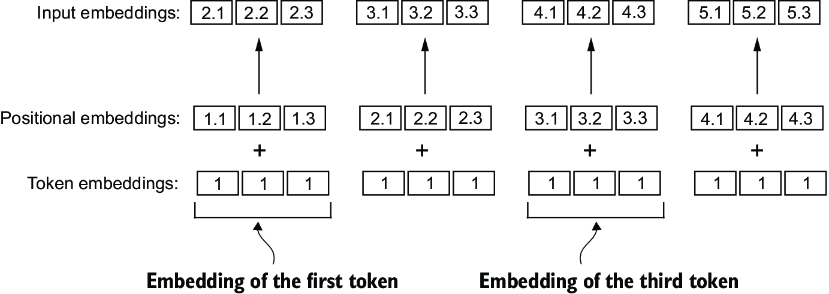

Positional embeddings are added to the token embedding vector to create the input embeddings for an LLM. The positional vectors have the same dimension as the original token embeddings. The token embeddings are shown with value 1 for simplicity.

## Relative positional embeddings

is on the relative position or distance between tokens. This means the model learns the relationships in terms of “how far apart” rather than “at which exact position.” The advantage here is that the model can generalize better to sequences of varying lengths, even if it hasn’t seen such lengths during training.

In [20]:
vocab_size = 50257
output_dim = 256
token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim)
token_embedding_layer

Embedding(50257, 256)

In [21]:
# Batch size of 8 with 4 tokens each, 8 * 4 * 256

window_length = 4
dataloader = create_dataloader_v1(raw_text, 8, window_length, window_length, shuffle=False)
dataloader_iter = iter(dataloader)
inputs, outputs = next(dataloader_iter)
inputs.shape
# 8 words input , 4 for each word

NameError: name 'raw_text' is not defined

In [ ]:
token_embedding = token_embedding_layer(inputs)
token_embedding.shape

In [22]:
# words
#-> create a Class  (tensor dataset) return [1. input words ids, 2. predict the next words ids] with encoder your choosed
#-> create dataloader with tiktoken encoder.return a tensor dataloader, [input, output(predict next word id)]
#-> use torch.nn.Embedding(datasize, output_dim) create a position matrix
#-> take the input from tensor dataloader apply to position matrix

For a GPT model’s absolute embedding approach, we just need to create another embedding layer that has the same embedding dimension as the token_embedding_ layer:

In [23]:
context_length = max_length = 4
pos_embedding_layer = torch.nn.Embedding(context_length, output_dim)
pos_embeddings = pos_embedding_layer(torch.arange(context_length))
print(pos_embeddings.shape)
pos_embeddings
# Note: layer is changeable even adopted to other layers
# pos_embedding_layer [changeable] -> torch.arange layer [static]

torch.Size([4, 256])


tensor([[ 0.8450,  0.3346, -0.2839,  ..., -0.7630, -0.1970, -0.6766],
        [-1.2667,  1.5775,  0.0668,  ...,  0.6369,  0.3437,  0.2013],
        [-0.4622, -0.7602,  0.1509,  ...,  1.5171, -0.4035,  0.9082],
        [ 0.5371,  0.2798, -0.7757,  ..., -1.5672,  0.8650, -0.1098]],
       grad_fn=<EmbeddingBackward0>)

**torch.nn.Embedding(context_length, output_dim)**

Creates a learnable lookup table (i.e. embedding matrix) of shape [context_length, output_dim].

Each index i from 0 to context_length - 1 maps to a vector of size output_dim.

**torch.arange(context_length)**

Generates the sequence [0, 1, 2, ..., context_length - 1]. These are the absolute positions in the input sequence.

**pos_embedding_layer(...)**

Looks up the embedding for each absolute position index.

So position 0 always maps to the same vector, position 1 to another, and so on.

Result shape: [context_length, output_dim]

One embedding vector per absolute position.

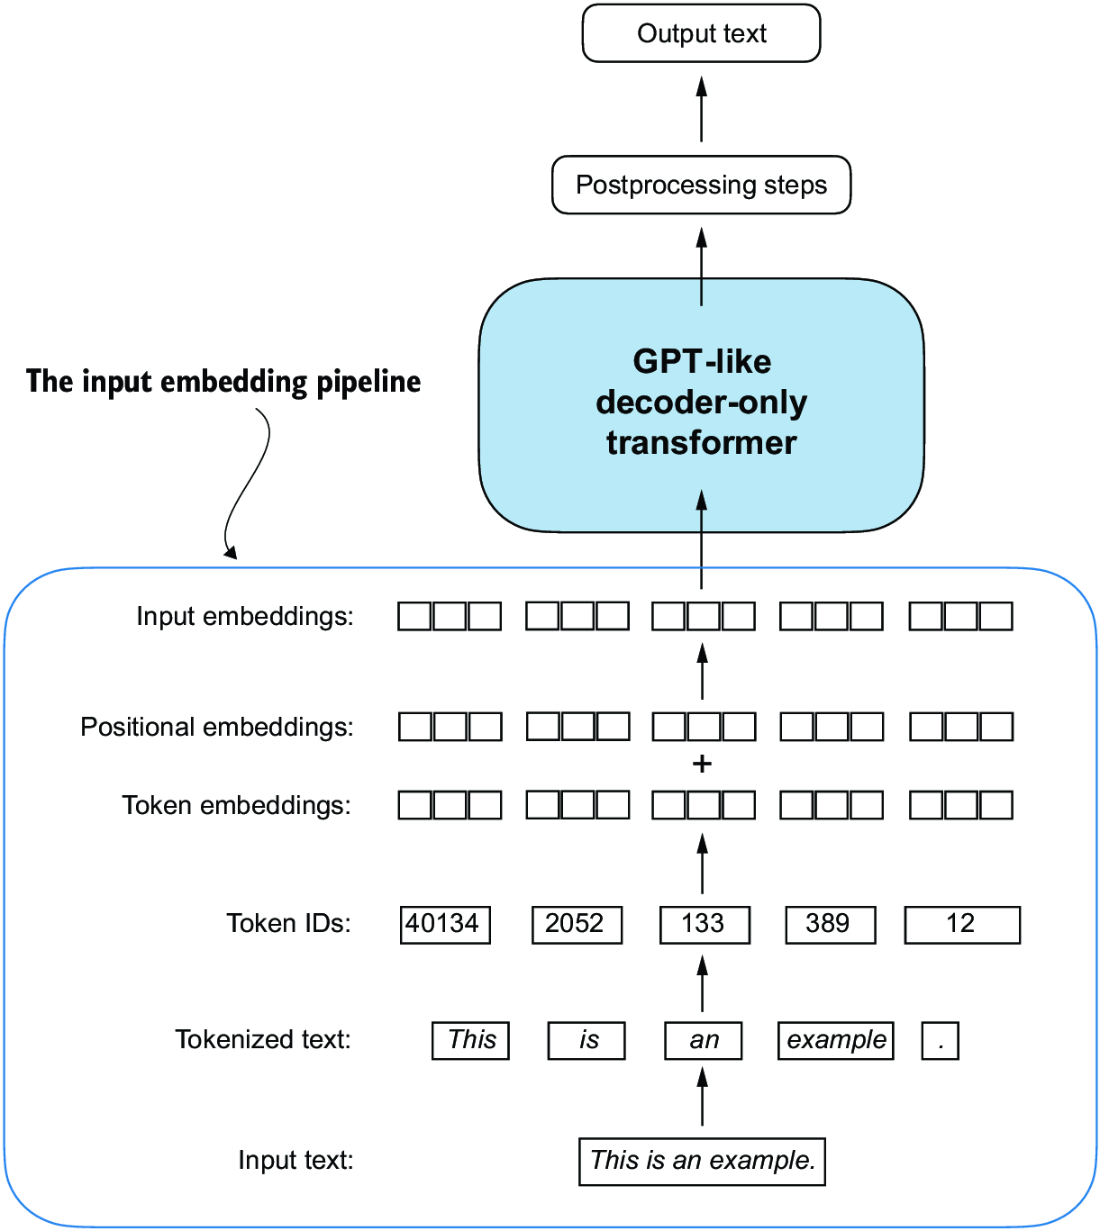

## SUMMARY

1. Raw text is broken into tokens, [words or charactors]
2. Tokens into integers -- token IDs
3. Handle special tokens: <|unk|> and <|endoftext|>
4. => BPE tokenizer -- tiktoken.get_encoding("gpt2")
5. Sliding window approach on tokenized data, input <-> predicted next word
6. Embedding layers in PyTorch function as a lookup operation, retrieving vectors corresponding to token IDs.
7. OpenAI’s GPT models utilize absolute positional embeddings, which are added to the token embedding vectors and are optimized during the model training.

## Start Token Embedding

In [24]:
pip install tiktoken

In [25]:
# 4. => BPE tokenizer -- tiktoken.get_encoding("gpt2")
import tiktoken
raw_text = "At this point, you know how to prepare the input text for training LLMs by splitting text into individual word and subword tokens, which can be encoded into vector representations, embeddings, for the LLM."
BPE_tokenizer_v1 = tiktoken.get_encoding("gpt2")
txt_encoding = BPE_tokenizer_v1.encode(raw_text)
txt_encoding[:5]

[2953, 428, 966, 11, 345]

In [26]:
#5. Sliding window approach on tokenized data, input <-> predicted next word

import torch
from torch.utils.data import Dataset, DataLoader

class GPT_Dataset(Dataset):
  def __init__(self, txt, tokenizer, window_size, steps):
    self.input_ids = []
    self.output_ids = []

    word_nums = tokenizer.encode(txt)
    for i in range(0, len(word_nums) - window_size, steps):
      tensor_input = torch.tensor(word_nums[i : i + window_size])
      tensor_output = torch.tensor(word_nums[i + 1 : i + window_size + 1])
      self.input_ids.append(tensor_input)
      self.output_ids.append(tensor_output)

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.output_ids[idx]



In [27]:
#Embedding layers in PyTorch function as a lookup operation, retrieving vectors corresponding to token IDs
def customize_dataloader(txt, batch_size=4, window_size=256, steps=128, shuffle=True, drop_last=True, num_workers=0):
  tokenizer = tiktoken.get_encoding("gpt2")
  dataset = GPT_Dataset(txt, tokenizer, window_size, steps)
  dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)
  return dataloader

with open("the-verdict.txt", "r") as fn:
    raw_txt = fn.read()

window_size = 4
dataloader = customize_dataloader(raw_text, 8, window_size, window_size, shuffle=False)
inputs, outputs = next(iter(dataloader))
inputs.shape


torch.Size([8, 4])

In [28]:
# OpenAI’s GPT models utilize absolute positional embeddings, which are added to the token embedding vectors and are optimized during the model training.

input_size = 50257
output_dim = 256
token_embedding_layer = torch.nn.Embedding(input_size, output_dim)
token_embedding = token_embedding_layer(inputs)
token_embedding.shape

torch.Size([8, 4, 256])

## Start Positional Embeddings

In [29]:
context_length = windew_size = 4
position_embedding_layer = torch.nn.Embedding(context_length, output_dim)
position_embedding = position_embedding_layer(torch.arange(context_length))
position_embedding.shape

torch.Size([4, 256])

## Start Input Embedding

In [30]:
input_embedding = token_embedding + position_embedding
input_embedding.shape

torch.Size([8, 4, 256])

# CHAPTER 3

## 3.1 The problem with modeling long sequence

The reasons for using attention mechanisms in neural networks


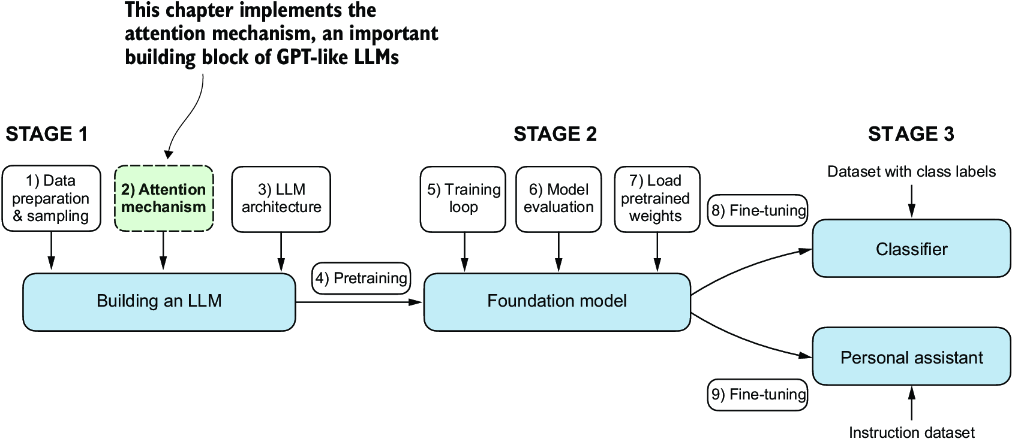

We will implement 4 different variants of attention machanism, These different attention variants build on each other. The goal is to arrive at a compact and efficient implementation fo multi-head attention that we can plug into the LLM.

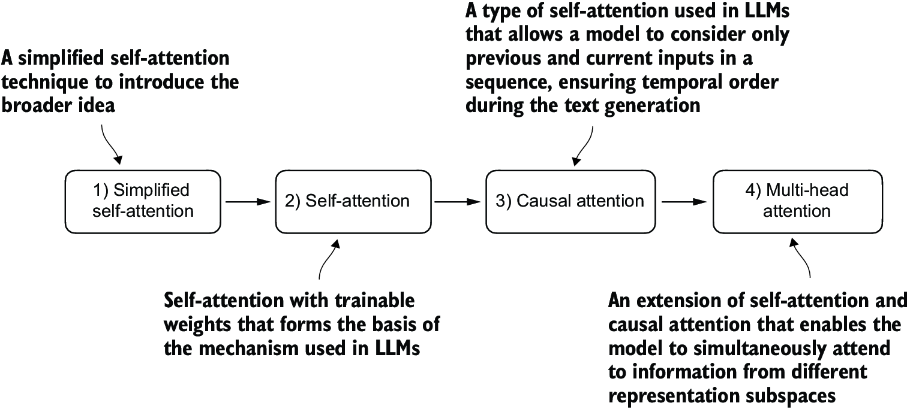

it’s not possible to merely translate word by word. Instead, the translation process requires contextual understanding and grammatical alignment.
!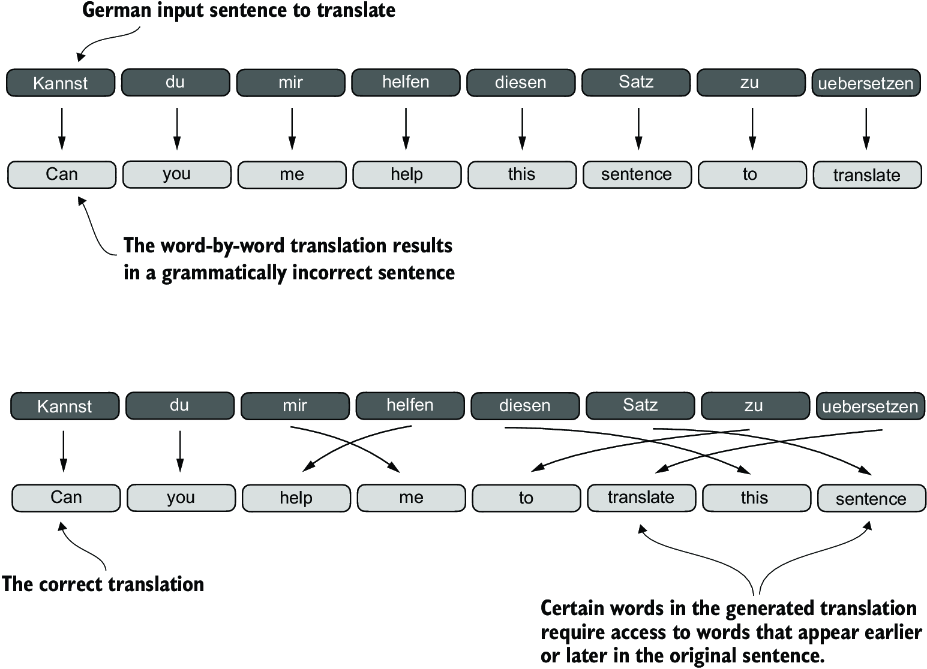

To address this problem, it is common to use a deep neural network with two submodules, an encoder and a decoder.

********

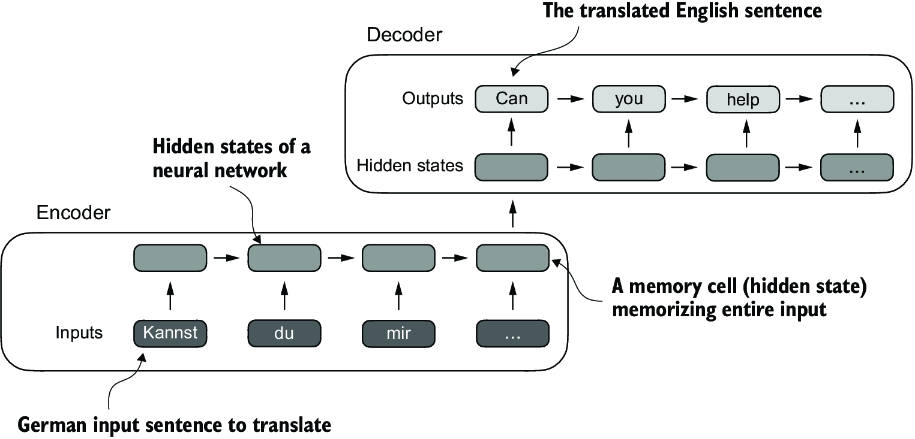

Before the advent of transformer models, encoder–decoder RNNs were a popular choice for machine translation. The encoder takes a sequence of tokens from the source language as input, where a hidden state (an intermediate neural network layer) of the encoder encodes a compressed representation of the entire input sequence. Then, the decoder uses its current hidden state to begin the translation, token by token.


**The big limitation of encoder–decoder RNNs is that the RNN can’t directly access earlier hidden states from the encoder during the decoding phase. Consequently, it relies solely on the current hidden state, which encapsulates all relevant information. This can lead to a loss of context, especially in complex sentences where dependencies might span long distances.**

## 3.2 Cpaturing data dependencies with attention mechanisms

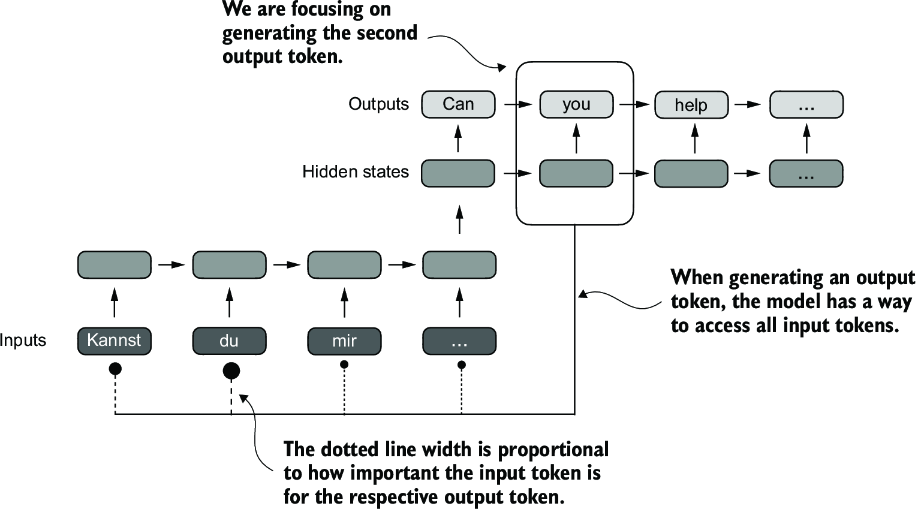

only three years later, researchers found that RNN architectures are not required for building deep neural networks for natural language processing and proposed the original transformer architecture.

Self-attention is a mechanism that allows each position in the input sequence to consider the relevancy of, or “attend to,” all other positions in the same sequence when computing the representation of a sequence. Self-attention is a **key component** of contemporary LLMs based on the transformer architecture, such as the GPT series.

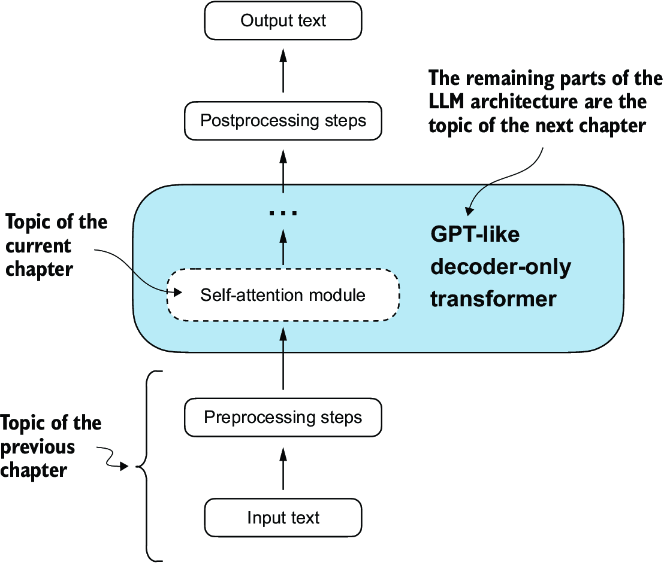

## 3.3 Attending to different parts of the input with self-attention.

The *“self”* refers to the mechanism’s ability to compute attention **weights** by relating different **positions** within a single input sequence.

### 3.3.1 A simple self-attention mechanism without trainable weights

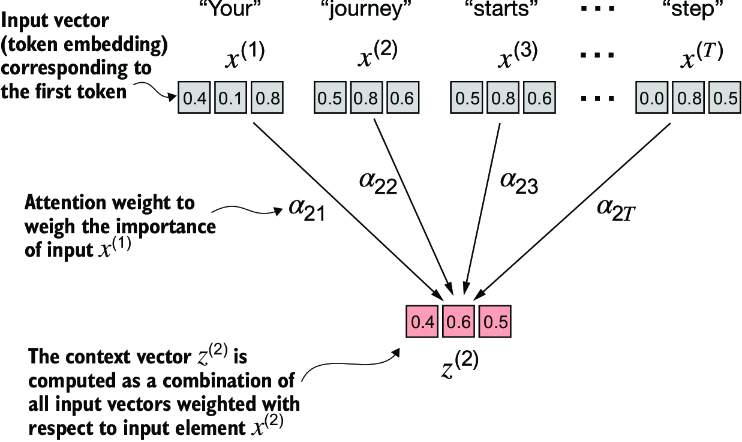

> *Context vectors* play a crucial role in self-attention. Their purpose is to create enriched representations of each element in an input sequence (like a sentence) by incorporating information from all other elements in the sequence


In [31]:
import torch
inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)

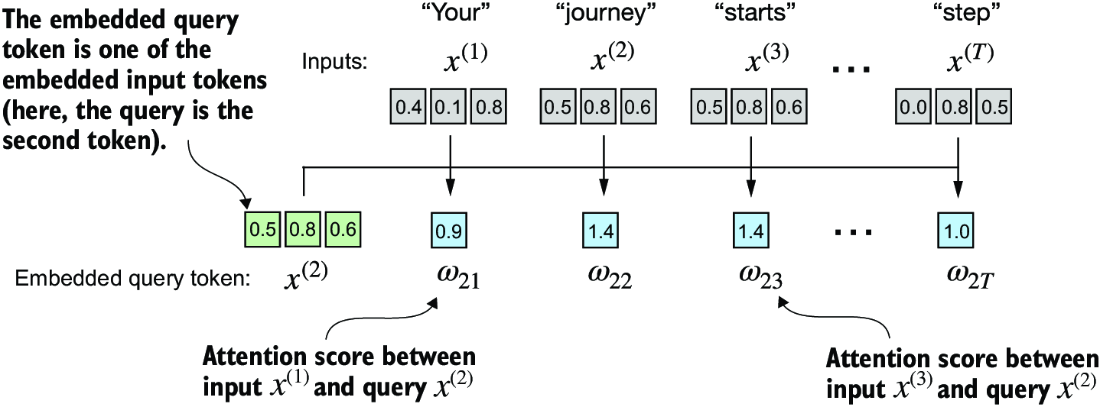

* 1. The first step: Compute the intermediate values w (Attention scores)
> *Why we not use the token embedding?* <br>
> 0.87 is truncated to 0.8. In this truncated version, the embeddings of the words “journey” and “starts” may appear similar by random chance.

In [32]:
# calculate the intermediate attention scores between the query token and each input token.
# We determine these scores by computing the dot product of the query, x(2), with every other input token:

second_word_query_token = inputs[1] # the second word's token
attention_score_to_second_word = torch.empty(inputs.shape[0]) # same shape with the first dim [6] of inputs [6, 3] but with uninitialized data
for num_index, matrix in enumerate(inputs):
  attention_score_to_second_word[num_index] = torch.dot(matrix, second_word_query_token)

attention_score_to_second_word

tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])

> the dot product is a measure of similarity because it quantifies ***how closely two vectors are aligned***: a higher dot product indicates a greater degree of alignment or similarity between the vectors. In the context of self-attention mechanisms, the dot product determines the extent to which each element in a sequence focuses on, or “attends to,” any other element: the higher the dot product, the higher the similarity and attention score between two elements.

* 2. The second step: Nomalize the weights. This normalization is a convvention that is useful for interpretation and maintaining training stability in an LLM.

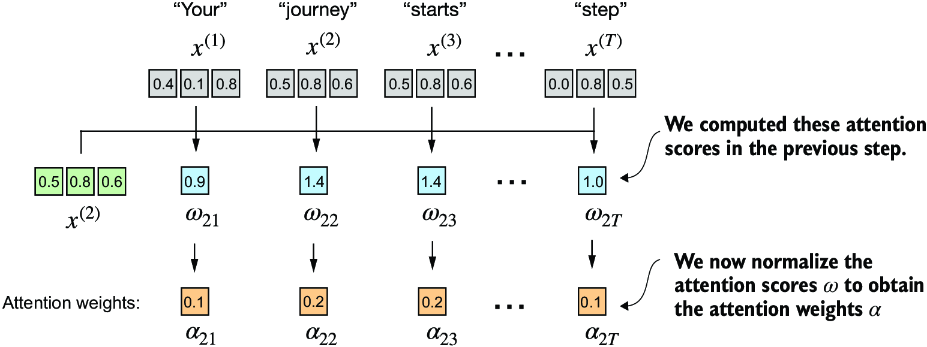
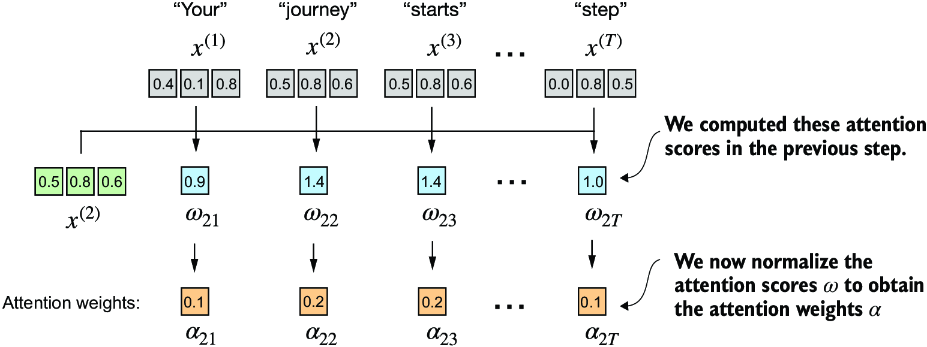

In [33]:
sum_of_weights = attention_score_to_second_word.sum()
normalize_weights = attention_score_to_second_word / sum_of_weights
normalize_weights

tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656])

> In practice, It's more common and advisable to use the *Softmax* function for normalization. In addition, the Softmax function always ensure the weights are positive. This makes output interpretable as probabilities or relative importance, where higher weights indicate greater importance.

In [34]:
# Attention weights respect to input 2

normalize_fn = torch.nn.Softmax(dim=0)
# or
softmax_result = torch.softmax(attention_score_to_second_word, dim=-1)
softmax_result

tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])

> The results are bit difference.
> 1.   tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656])
> 2.   tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
> ***
> It becauses the Softmax takes exponation of each value.
> Softmax = exp(tensor_i) / sum (exp (tensor))
> Make difference more obviously.


* 3. Calculating the context vector z(2) by **multiplying** the embedded input tokens x(i), with the corresponding weights and then **summing** the resulting vecetors.
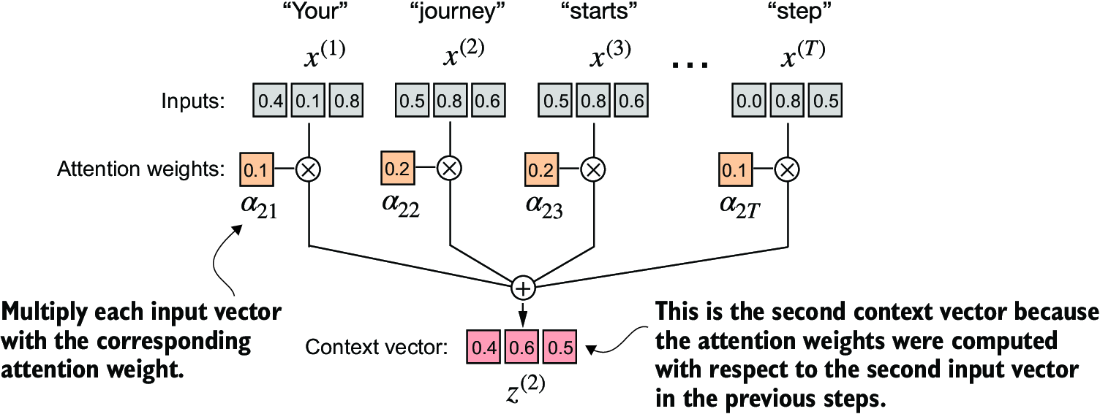

In [35]:
# Context vector for input 2
# the context vector should have same shape with the query's shape.
#从inputs encoded 变成 context vector, 目的是通过dim不变的情况下,让所有的vector之间通过weights产生连接.
query = inputs[1]

context_vector_v2 = torch.zeros(query.shape)
for idx, matrix in enumerate(inputs):
  context_vector_v2 += matrix * softmax_result[idx]

context_vector_v2

tensor([0.4419, 0.6515, 0.5683])

### 3.3.2 Computing attention weights for all input tokens

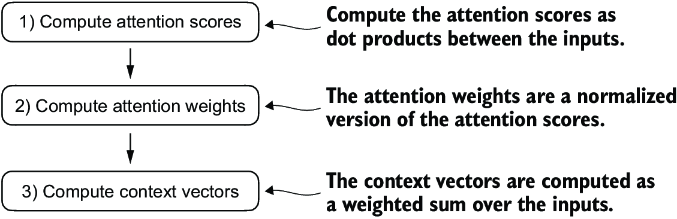

> COMPUTE ATTENTION SCORES。=> matrix @ matrix.T

Step 1, Token embedding for each of them.

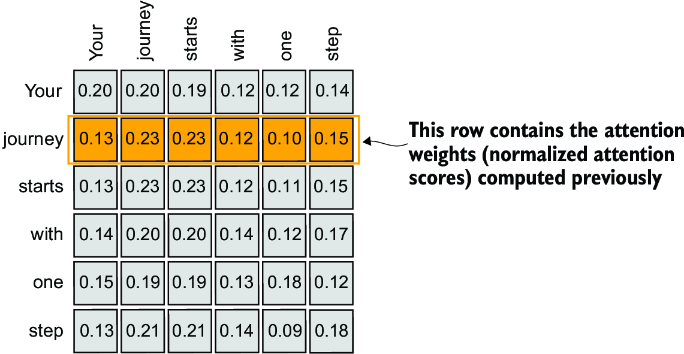

In [36]:
# Dot product for each 1-1 2-1 3-1 ...2-1 2-2 3-2...6-6

len_words = inputs.shape[0]
attention_score_matrix = torch.empty(len_words, len_words)
for row_index, row_value in enumerate(inputs):
  for col_index, cal_value in enumerate(inputs):
    attention_score_matrix[row_index, col_index] = torch.dot(row_value, cal_value)

attention_score_matrix

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])

⏬

In [37]:
# Faster process for Dot product
# matrix @ matrix.T
attention_score_matrix = inputs @ inputs.T
attention_score_matrix

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])

In [38]:
normalize_weights = torch.softmax(attention_score_matrix, dim=-1)
normalize_weights

tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.1295],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])

> Step 3: Use attention weights to compute all context vectors.
> weights martix @ original matrix

In [39]:
all_context_vectors = normalize_weights @ inputs
all_context_vectors

tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])

## 3.4 Implementing self-attention with trainable weights

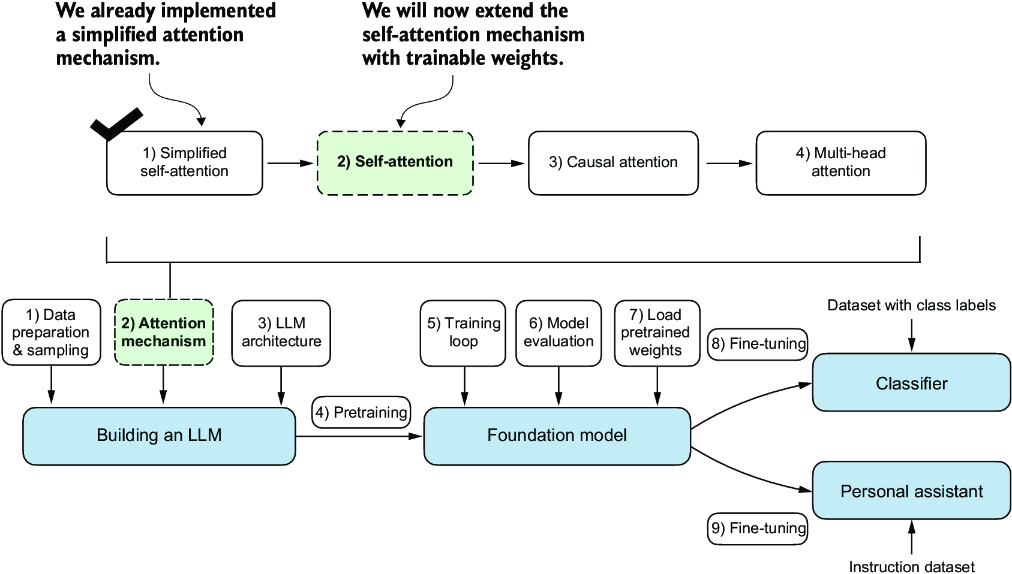

### 3.4.1 Computing the attention weights step by step

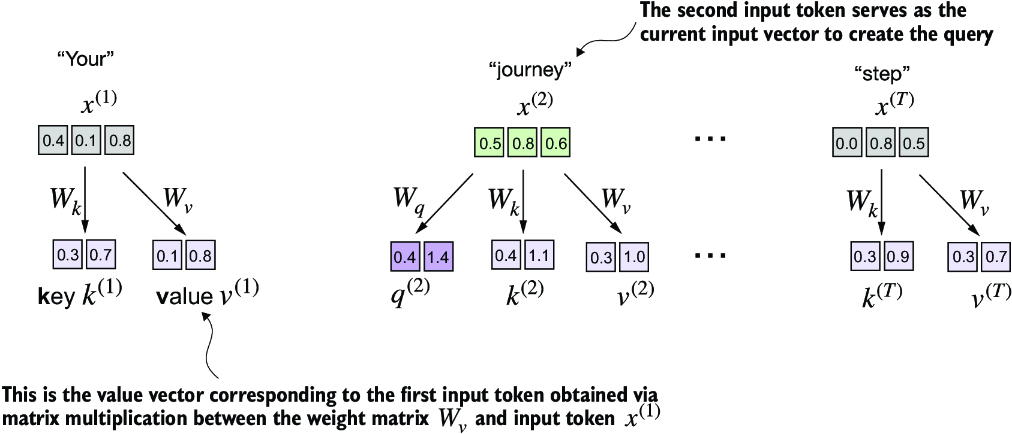

In [40]:
inputs

tensor([[0.4300, 0.1500, 0.8900],
        [0.5500, 0.8700, 0.6600],
        [0.5700, 0.8500, 0.6400],
        [0.2200, 0.5800, 0.3300],
        [0.7700, 0.2500, 0.1000],
        [0.0500, 0.8000, 0.5500]])

Trainable weight matrices: Wq, Wk, and Wv.
> In the first step of the self-attention mechanism with trainable weight matrices, we compute query (q), key (k), and value (v) vectors for input elements x. Similar to previous sections, we designate the second input, x(2), as the query input. The query vector q(2) is obtained via matrix multiplication between the input x(2) and the weight matrix Wq. Similarly, we obtain the key and value vectors via matrix multiplication involving the weight matrices Wk and Wv.

Example, We start by computing only one context vector, z2, for illustration purposes. Just like the image.

*Step - 1*

In [41]:
'''
the input and output dimensions are usually the same,
but to better follow the computation, we’ll use different。
'''
x_2 = inputs[1]
dim_in = inputs.shape[1]
dim_out = 2

'''
Initialize Wq, Wk, Wv

We set requires_grad=False to reduce clutter in the outputs,
but if we were to use the weight matrices for model training,
we would set requires_grad=True to update these matrices during model training.
'''
torch.manual_seed(123)
W_query = torch.nn.Parameter(torch.rand(dim_in, dim_out), requires_grad=False)
W_key = torch.nn.Parameter(torch.rand(dim_in, dim_out), requires_grad=False)
W_value = torch.nn.Parameter(torch.rand(dim_in, dim_out), requires_grad=False)

'''
Compute the query, key and value vectors, as showing in the image.
'''
query_2 = x_2 @ W_query
key_2 = x_2 @ W_key
value_2 = x_2 @ W_value

key_2, W_query.shape


(tensor([0.4433, 1.1419]), torch.Size([3, 2]))

> **`Weight parameters vs. attention weights`**
weight parameters are the fundamental, learned coefficients that define the network’s connections, while attention weights are dynamic, context-specific values.


* Weight Parameters = model’s permanent knowledge
* Attention Weights = model’s temporary focus on a specific input



In [42]:
keys = inputs @ W_key
values = inputs @ W_value

keys, values

(tensor([[0.3669, 0.7646],
         [0.4433, 1.1419],
         [0.4361, 1.1156],
         [0.2408, 0.6706],
         [0.1827, 0.3292],
         [0.3275, 0.9642]]),
 tensor([[0.1855, 0.8812],
         [0.3951, 1.0037],
         [0.3879, 0.9831],
         [0.2393, 0.5493],
         [0.1492, 0.3346],
         [0.3221, 0.7863]]))

*Step - 2*

Computing the attention scores.
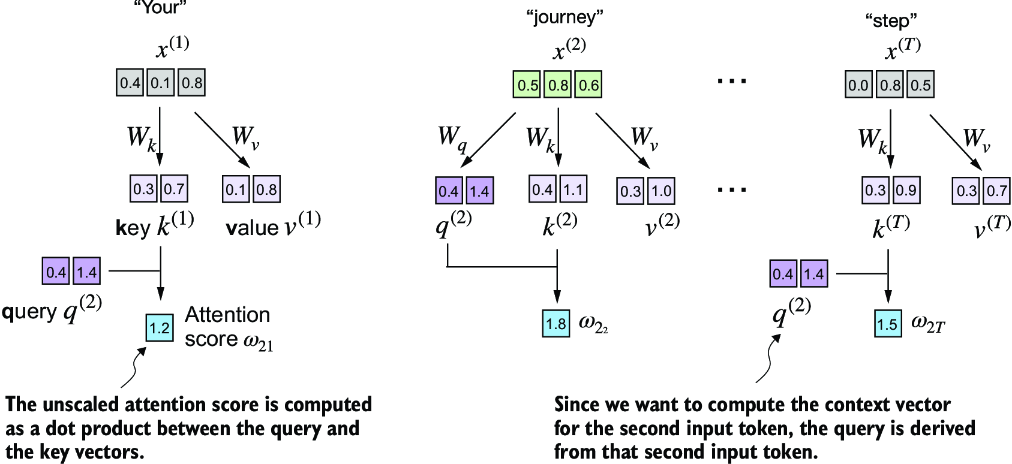

In [43]:
'''
Attention score for x2
'''
w2 = query_2.dot(key_2)

'''
Generalize this computation to all attention scores via matrix mulitiplication:
1*3 @ 3*6 = 1*6
'''
attention_score_2 = query_2 @ keys.T
attention_score_2

'''
Go from attention scores to the attention Weights.
Scale the attention scores by dividing them by the square root of the embedding dimension of the keys
'''
d_k = keys.shape[-1] # 2
attention_weights_2 = torch.softmax(attention_score_2 / d_k ** 0.5, dim = -1)
w2, attention_score_2, attention_weights_2

(tensor(1.8524),
 tensor([1.2705, 1.8524, 1.8111, 1.0795, 0.5577, 1.5440]),
 tensor([0.1500, 0.2264, 0.2199, 0.1311, 0.0906, 0.1820]))

Weights:

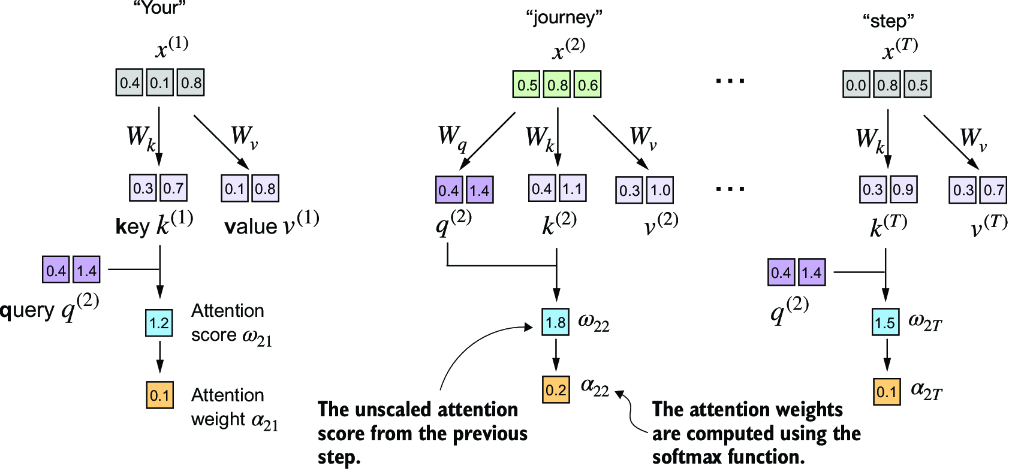

**The rationale behind scaled-dot product attention** <br>
The reason for the normalization by the embedding dimension size is to improve the training performance by avoiding small gradients. For instance, when scaling up the embedding dimension, which is typically greater than 1,000 for GPT-like LLMs, large dot products can result in very small gradients during backpropagation due to the softmax function applied to them. As dot products increase, the softmax function behaves more like a step function, resulting in gradients nearing zero. These small gradients can drastically slow down learning or cause training to stagnate.

The scaling by the square root of the embedding dimension is the reason why this self-attention mechanism is also called scaled-dot product attention.


*Final step*

Compute the context vectors.

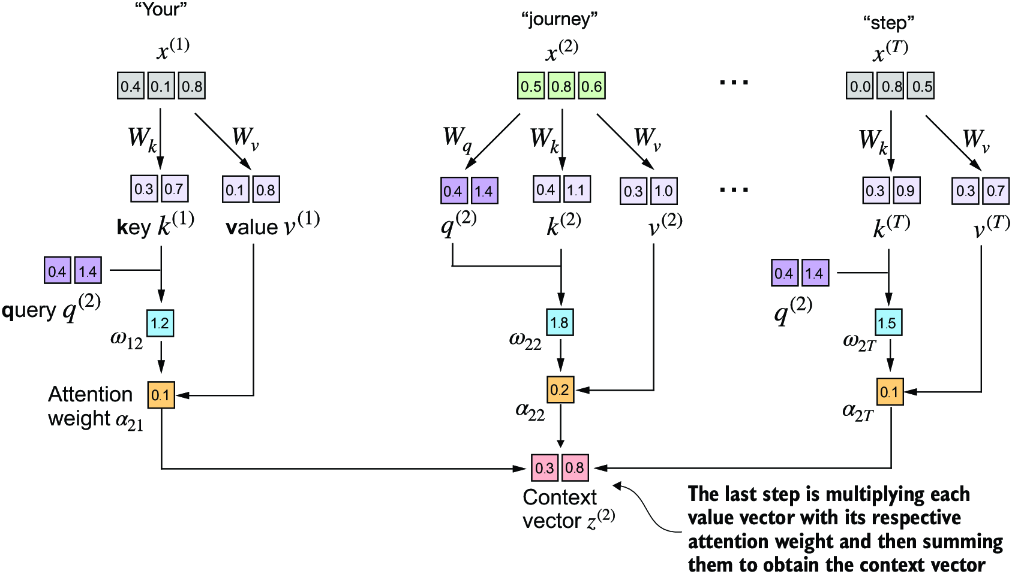

In [44]:
context_vector = attention_weights_2 @ values
context_vector, attention_weights_2.shape, values.shape

(tensor([0.3061, 0.8210]), torch.Size([6]), torch.Size([6, 2]))

>REMEMBER THIS IS ONLY FOR A SINGLE CONTEXT VECTOR z_2

****
**🔰 Why Query, Key and Value?**
>The terms “key,” “query,” and “value” in the context of attention mechanisms are borrowed from the domain of information retrieval and databases, where similar concepts are used to store, search, and retrieve information.
- A query is analogous to a search query in a database. It represents the current item (e.g., a word or token in a sentence) the model focuses on or tries to understand. The query is used to probe the other parts of the input sequence to determine how much attention to pay to them.
- The key is like a database key used for indexing and searching. In the attention mechanism, each item in the input sequence (e.g., each word in a sentence) has an associated key. These keys are used to match the query.
- The value in this context is similar to the value in a key-value pair in a database. It represents the actual content or representation of the input items. Once the model determines which keys (and thus which parts of the input) are most relevant to the query (the current focus item), it retrieves the corresponding values.
****

###3.4.2 Implementing a compact self-attention Python class


In [45]:
import torch.nn as nn
class SelfAttention_v1(nn.Module):
  def __init__(self, dim_in, dim_out) -> None:
    super().__init__()
    self.W_query = nn.Parameter(torch.rand(dim_in, dim_out))
    self.W_key = nn.Parameter(torch.rand(dim_in, dim_out))
    self.W_value = nn.Parameter(torch.rand(dim_in, dim_out))

  def forward(self, query_focus):
    keys = query_focus @ self.W_key
    queries = query_focus @ self.W_query
    values = query_focus @ self.W_value
    attention_scores = queries @ keys.T
    attention_weights = torch.softmax(attention_scores / keys.shape[-1] ** 0.5, dim = -1)
    context_vec = attention_weights @ values
    return context_vec

'''
Let's check
'''
dim_in, dim_out
torch.manual_seed(123)
v1_module = SelfAttention_v1(dim_in, dim_out)
v1_module(inputs)

tensor([[0.2996, 0.8053],
        [0.3061, 0.8210],
        [0.3058, 0.8203],
        [0.2948, 0.7939],
        [0.2927, 0.7891],
        [0.2990, 0.8040]], grad_fn=<MmBackward0>)

Steps:
1. Input vectors -> Input Matrix X [tiktoken, window slider, Token embedding]
2. Wq, Wk, Wv.  query_x @ [torch.nn.Parameter(torch.rand(dim_in, dim_out), requires_grad=False)] -> Q, K, V
3. attention_score = Q@ K.T <br>
   -> attention_weight = torch.softmax(attention_score / keys.shape[-1] ** 0.5, dim=-1)<br>
   -> context_vector = attention_weight @ V

**A self-attention class using Pytorch linear layers:**

In [46]:
class SelfAttention_v2(nn.Module):
  def __init__(self, d_in, d_out, qkv_bias=False):
    super().__init__()
    self.w_query = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.w_key = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.w_value = nn.Linear(d_in, d_out, bias=qkv_bias)

  def forward(self, x):
    keys = self.w_key(x)
    queries = self.w_query(x)
    values = self.w_value(x)
    attention_scores = queries @ keys.T
    attention_weights = torch.softmax(attention_scores / keys.shape[-1] ** 0.5, dim=-1)
    context_vecter = attention_weights @ values
    return context_vecter

# class SelfAttention_v1(nn.Module):
#   def __init__(self, dim_in, dim_out) -> None:
#     super().__init__()
#     self.W_query = nn.Parameter(torch.rand(dim_in, dim_out))
#     self.W_key = nn.Parameter(torch.rand(dim_in, dim_out))
#     self.W_value = nn.Parameter(torch.rand(dim_in, dim_out))

#   def forward(self, query_focus):
#     keys = query_focus @ self.W_key
#     queries = query_focus @ self.W_query
#     values = query_focus @ self.W_value
#     attention_scores = queries @ keys.T
#     attention_weights = torch.softmax(attention_scores / keys.shape[-1] ** 0.5, dim = -1)
#     context_vec = attention_weights @ values
#     return context_vec

In [47]:
torch.manual_seed(789)
sa_v2 = SelfAttention_v2(dim_in, dim_out)
out_put = sa_v2(inputs)
out_put

tensor([[-0.0739,  0.0713],
        [-0.0748,  0.0703],
        [-0.0749,  0.0702],
        [-0.0760,  0.0685],
        [-0.0763,  0.0679],
        [-0.0754,  0.0693]], grad_fn=<MmBackward0>)

> <h3><b>Compare SelfAttention_v1 and v2:</b></h3>
> Note that nn.Linear in SelfAttention_v2 uses a different weight initialization scheme as nn.Parameter(torch.rand(d_in, d_out)) used in SelfAttention_v1, which causes both mechanisms to produce different results. To check that both implementations, SelfAttention_v1 and SelfAttention_v2, are otherwise similar, we can transfer the weight matrices from a SelfAttention_v2 object to a SelfAttention_v1, such that both objects then produce the same results.



In [48]:
'''
our task is to correctly assign the weights from an instance of SelfAttention_v2
to an instance of SelfAttention_v1. To do this, you need to understand the
relationship between the weights in both versions. (Hint: nn.Linear stores the
weight matrix in a transposed form.) After the assignment, you should observe
that both instances produce the same outputs.
'''

def transfer_weights(sa_v2, sa_v1):
    # Transfer the weights from sa_v2 to sa_v1
    with torch.no_grad(): # tell the model this part not for backpropagation
        sa_v1.W_query.copy_(sa_v2.w_query.weight.T)
        sa_v1.W_key.copy_(sa_v2.w_key.weight.T)
        sa_v1.W_value.copy_(sa_v2.w_value.weight.T)
# Initialize both modules
sa_v2 = SelfAttention_v2(dim_in, dim_out)
sa_v1 = SelfAttention_v1(dim_in, dim_out)

# Transfer weights
transfer_weights(sa_v2, sa_v1)

# Test on some input
out1 = sa_v1(inputs)
out2 = sa_v2(inputs)

# Check closeness
print(torch.allclose(out1, out2, atol=1e-6))  # Should print: True

True


> Attention(Q,K,V)=softmax(Q⋅K.T/√dk)⋅V


## 3.5 Hiding future words with <font color='red'>causal attention</font>

> Attention(Q,K,V)=softmax(Q⋅K.T/√dk)⋅V


Causal attention, also known as masked attention, is a specialized form of self-attention. It restricts a model to only consider previous and current inputs in a squence when processing any given token when computing attention scores.

[-> this is in CONTRAST to the standard self-attention mechanism.<-]

In [49]:
# token_3 ↔ token_1, token_2, token_3, token_4, token_5 ✅

# 因果 attention（单向）：
# token_3 → token_1, token_2, token_3 ✅
#           ⛔ 不允许看到 token_4, token_5


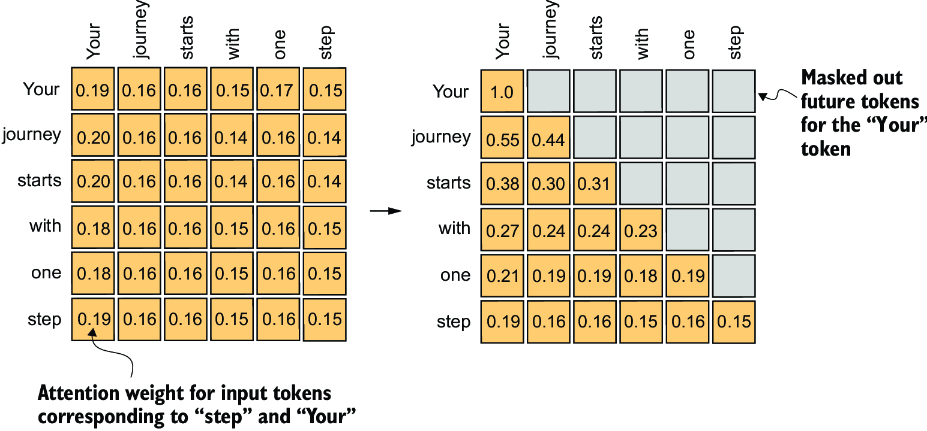

####3.5.1 Applying a causal attention mask.

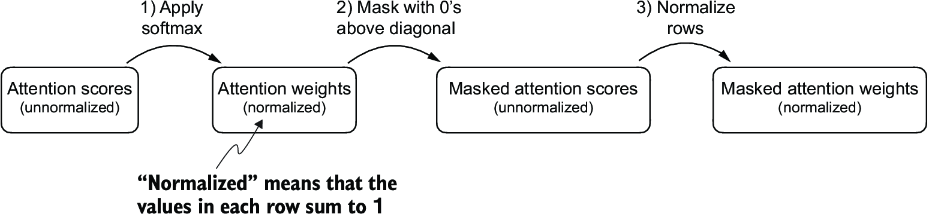

In [50]:
# 1. Attention scores -> softmax -> attention weights
values = sa_v2.w_value(inputs)
keys = sa_v2.w_key(inputs)
queries = sa_v2.w_query(inputs)
attention_scores = queries @ keys.T
attention_weights = torch.softmax(attention_scores / keys.shape[-1] ** 0.5, dim = -1)

# torch.tril
# PyTorch’s tril function to create a mask where the values above the diagonal are zero
mask_weights = torch.tril(attention_weights)
mask_weights

tensor([[0.1766, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1772, 0.1720, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1769, 0.1719, 0.1716, 0.0000, 0.0000, 0.0000],
        [0.1725, 0.1696, 0.1695, 0.1618, 0.0000, 0.0000],
        [0.1687, 0.1694, 0.1692, 0.1637, 0.1634, 0.0000],
        [0.1758, 0.1704, 0.1702, 0.1598, 0.1615, 0.1623]],
       grad_fn=<TrilBackward0>)

In [51]:
# Normalize the mask_weights
'''
Can't use torch.softmax straightly. all value 0.000s will be considered to be signed a value,
but we don't want to. We can signed with -infi to 0s, solution after this part.
'''
row_sum = mask_weights.sum(dim=-1, keepdim=True)
'''
keepdim: Ensure the output have the same dim with input. otherwise, it will be
1 dim.

tensor([[0.1921],
        [0.3700],
        [0.5357],
        [0.6775],
        [0.8415],
        [1.0000]], grad_fn=<SumBackward1>)

vs.

tensor([0.1921, 0.3700, 0.5357, 0.6775, 0.8415, 1.0000],
       grad_fn=<SumBackward1>)
'''
nlm_weight = mask_weights / row_sum
nlm_weight

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5075, 0.4925, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3399, 0.3303, 0.3298, 0.0000, 0.0000, 0.0000],
        [0.2562, 0.2519, 0.2517, 0.2402, 0.0000, 0.0000],
        [0.2021, 0.2030, 0.2028, 0.1962, 0.1959, 0.0000],
        [0.1758, 0.1704, 0.1702, 0.1598, 0.1615, 0.1623]],
       grad_fn=<DivBackward0>)

Information leakage
>after masking and renormalization, the distribution of attention weights is as if it was calculated only among the unmasked positions to begin with. This ensures there’s no information leakage from future (or otherwise masked) tokens as we intended.

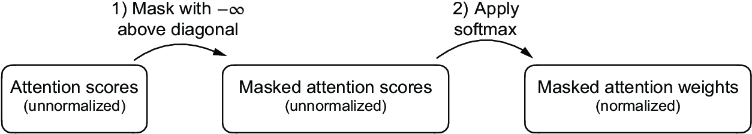

In [52]:
'''
-infi solutions: Reduce the overfitting
'''

length, height = attention_scores.shape
masks = torch.triu(torch.ones(length, height), diagonal=1)
# tensor([[0., 1., 1., 1., 1., 1.],
#         [0., 0., 1., 1., 1., 1.],
#         [0., 0., 0., 1., 1., 1.],
#         [0., 0., 0., 0., 1., 1.],
#         [0., 0., 0., 0., 0., 1.],
#         [0., 0., 0., 0., 0., 0.]])
inf_masks = attention_scores.masked_fill(masks.bool(), -torch.inf)
# tensor([[0.2899,   -inf,   -inf,   -inf,   -inf,   -inf],
#         [0.4656, 0.1723,   -inf,   -inf,   -inf,   -inf],
#         [0.4594, 0.1703, 0.1731,   -inf,   -inf,   -inf],
#         [0.2642, 0.1024, 0.1036, 0.0186,   -inf,   -inf],
#         [0.2183, 0.0874, 0.0882, 0.0177, 0.0786,   -inf],
#         [0.3408, 0.1270, 0.1290, 0.0198, 0.1290, 0.0078]],
#        grad_fn=<MaskedFillBackward0>)
attention_weights = torch.softmax(inf_masks / keys.shape[-1] ** 0.5, dim=-1)

context_v = attention_weights @ values
attention_weights, context_v

(tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.5075, 0.4925, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.3399, 0.3303, 0.3298, 0.0000, 0.0000, 0.0000],
         [0.2562, 0.2519, 0.2517, 0.2402, 0.0000, 0.0000],
         [0.2021, 0.2030, 0.2028, 0.1962, 0.1959, 0.0000],
         [0.1758, 0.1704, 0.1702, 0.1598, 0.1615, 0.1623]],
        grad_fn=<SoftmaxBackward0>),
 tensor([[ 0.2482, -0.4838],
         [ 0.3715, -0.4308],
         [ 0.4156, -0.4117],
         [ 0.3776, -0.3530],
         [ 0.3981, -0.3243],
         [ 0.3672, -0.3085]], grad_fn=<MmBackward0>))

A more efficient way to obtain the masked attention weight matrix in causal attention is to mask the attention scores with negative infinity values before applying the softmax function

#### 3.5.2 Masking additional attention weights with <font color='red'>DROPOUT</font>



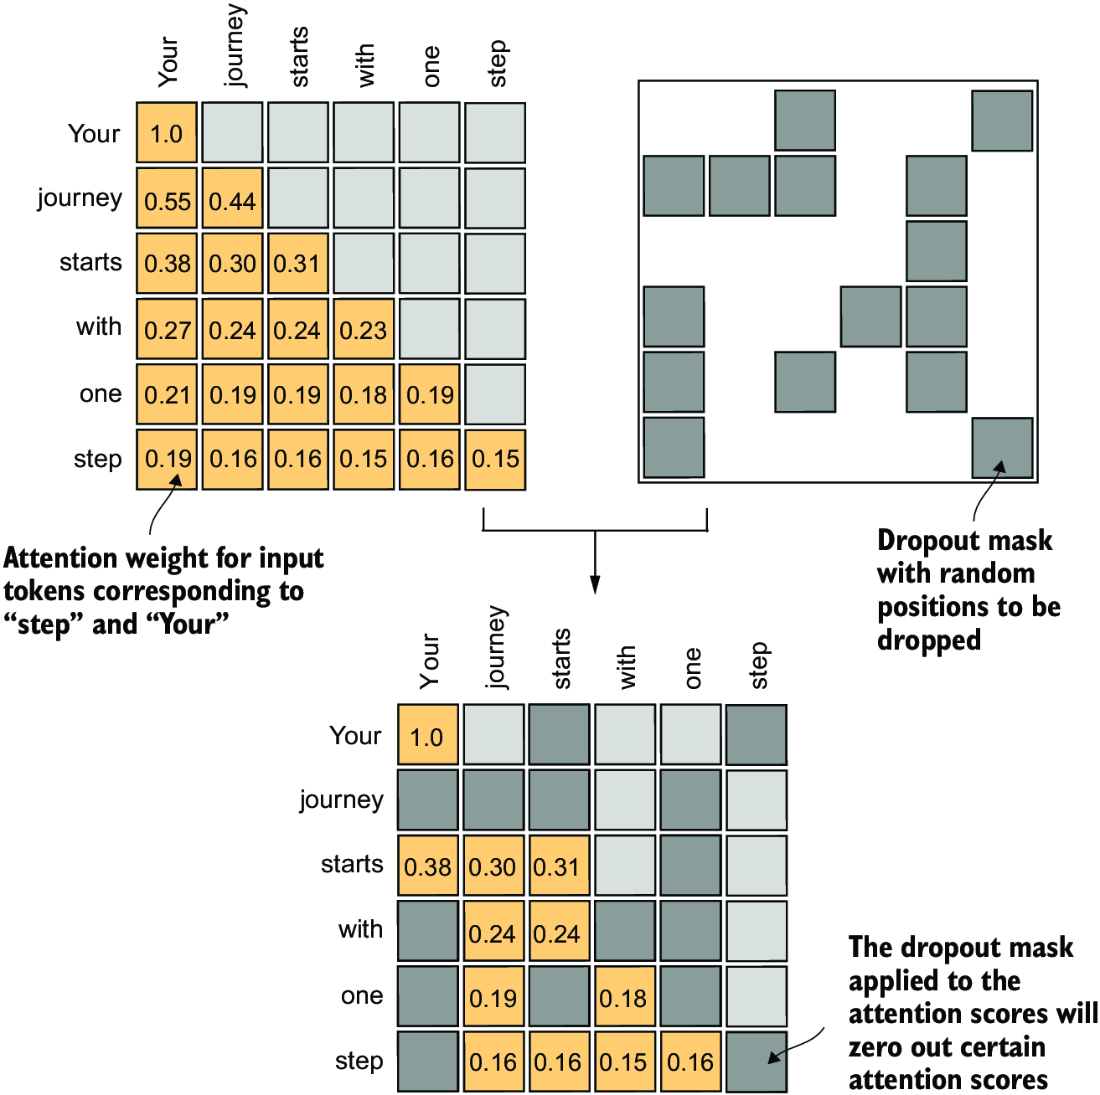

>Dropout in deep learning is a technique where randomly selected hidden layer units are ignored during training. Effectively "dropping" them out. This method helps prevent overfitting by ensuring that a model does NOT become overly reliant on any specific set of hidden layer units.
***
>In the transformer architecture, including models like GPT, dropout in the attention mechanism is typically applied at two specific times: after calculating the attention weights or after applying the attention weights to the value vectors

In [53]:
torch.manual_seed(123)
dropout = torch.nn.Dropout(0.5) # Dropout rate 50%
weights_dropout = dropout(attention_weights)
weights_dropout

tensor([[2.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.9849, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.6595, 0.0000, 0.0000, 0.0000],
        [0.5124, 0.5038, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4043, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.3408, 0.0000, 0.0000, 0.0000, 0.0000]],
       grad_fn=<MulBackward0>)

#### 3.5.3 Implementing a compact <font color='red'>causal attention class</font>

<font color='red'>Compact Causal Attention Class</font>

In [54]:
import torch.nn as nn

class CausalAttention(nn.Module):
  def __init__(self, d_in, d_out, context_length, dropout, qkv_bias = False):
    super().__init__()

    self.W_query = nn.Linear(d_in, d_out, bias = qkv_bias) # Note: 尽管parameters是d_in， d_out，但是，W 的 shape 是（d_out，d_in）
    self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.dropout = nn.Dropout(dropout)

    self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal = 1))

  def forward(self, vector):
    _, num_tokens, d_in = vector.shape
    keys = self.W_key(vector)
    values = self.W_value(vector)
    queries = self.W_query(vector)

    attention_score = queries @ keys.transpose(1, 2)

    attention_score.masked_fill_(
        self.mask.bool()[:num_tokens, :num_tokens], -torch.inf
        # 确保 mask has same size of the vector， otherwise raise a shape mismatch.
    )

    attention_weights = torch.softmax(
        attention_score / keys.shape[-1] ** 0.5, dim=-1
    )

    attention_weights = self.dropout(attention_weights)

    context_vector = attention_weights @ values

    return context_vector

In [55]:
# inputs = torch.tensor(
#   [[0.43, 0.15, 0.89], # Your     (x^1)
#    [0.55, 0.87, 0.66], # journey  (x^2)
#    [0.57, 0.85, 0.64], # starts   (x^3)
#    [0.22, 0.58, 0.33], # with     (x^4)
#    [0.77, 0.25, 0.10], # one      (x^5)
#    [0.05, 0.80, 0.55]] # step     (x^6)
# )
# Create batch of size 2
batch = torch.stack((inputs, inputs), dim=0)  # shape = (2, 6, 3)

# Set dimensions
d_in = batch.shape[-1]
d_out = 2

# Create and run model
torch.manual_seed(123)
context_length = batch.shape[1]
ca = CausalAttention(d_in, d_out, context_length, dropout=0.0)
context_vecs = ca(batch)

print("context_vecs.shape:", context_vecs.shape)

context_vecs.shape: torch.Size([2, 6, 2])


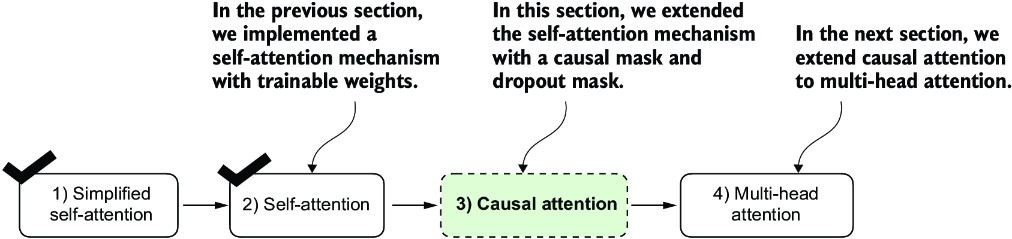

## 3.6 Extending single-head attention to <font color='red'>multi-head attention</font>


Multi-head: Dividing the attention mechanism into multiple heads, each operating independently.

There is only ONE set of attention weights processing the input sequentially.

#### 3.6.1 Stacking multiple single-head attention layers


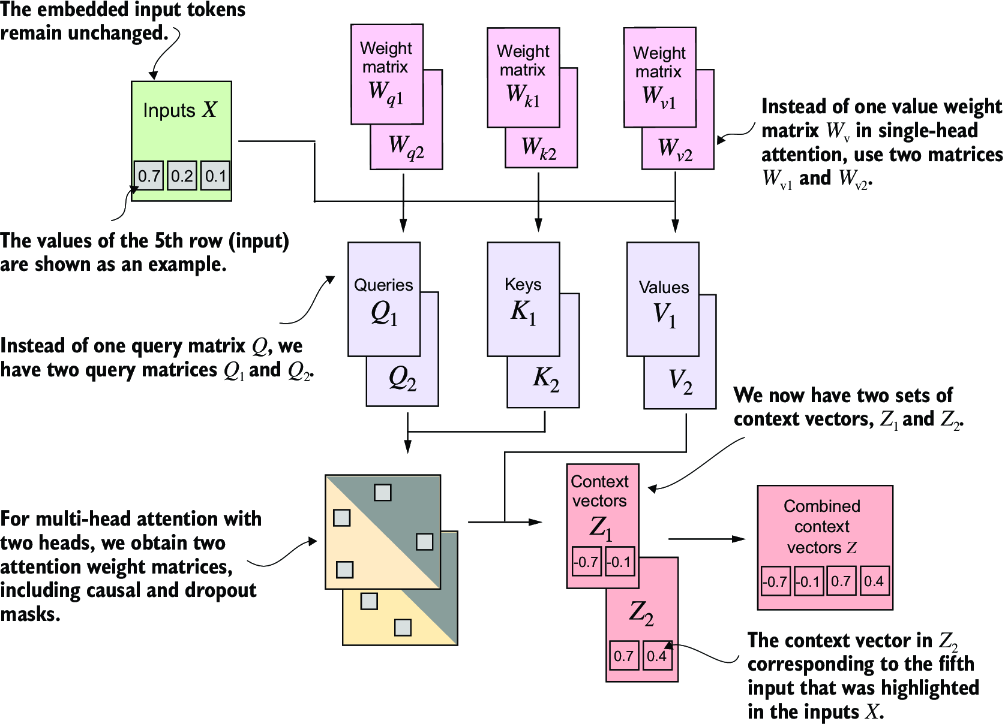

The main idea behind multi-head attention is to run the attention mechanism multiple times (in parallel) with different, learned linear projections—the results of multiplying the input data (like the query, key, and value vectors in attention mechanisms) by a weight matrix.

In [56]:
class MultiHeadAttentionWrapper(nn.Module):
  def __init__(self, d_in, d_out, context_length,
                 dropout, num_heads, qkv_bias=False):
    super().__init__()

    self.heads = nn.ModuleList(
            [CausalAttention(
                  d_in, d_out, context_length, dropout, qkv_bias
              )
              for _ in range(num_heads)]
        )

  def forward(self, x):
      return torch.cat([head(x) for head in self.heads], dim=-1)

- self.heads -> A nn.ModuleList contains a list of CausalAttention, the length depend on the number of heads are needed.

- torch.cat -> merge ModeleList together base on dim requirement. CausalAttention's shape is (a, b, c), when dim=-1, the torch.cat should only consider c.

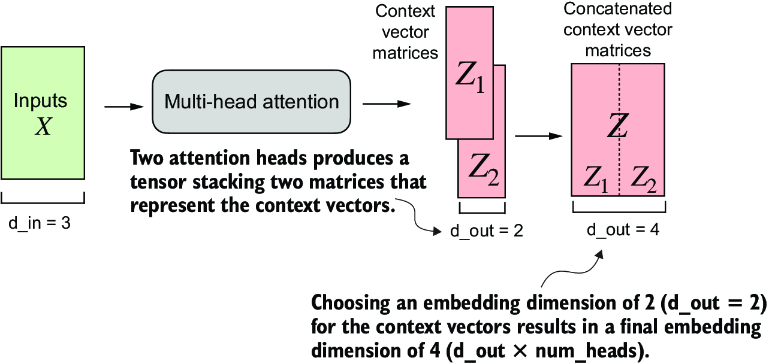

In [57]:
torch.manual_seed(123)
context_length = batch.shape[1]
d_in, d_out = 3, 2
mha = MultiHeadAttentionWrapper(
    d_in, d_out, context_length, 0.0, num_heads=2
)
context_vecs = mha(batch)


batch.shape, mha, context_vecs, context_vecs.shape

(torch.Size([2, 6, 3]),
 MultiHeadAttentionWrapper(
   (heads): ModuleList(
     (0-1): 2 x CausalAttention(
       (W_query): Linear(in_features=3, out_features=2, bias=False)
       (W_key): Linear(in_features=3, out_features=2, bias=False)
       (W_value): Linear(in_features=3, out_features=2, bias=False)
       (dropout): Dropout(p=0.0, inplace=False)
     )
   )
 ),
 tensor([[[-0.4519,  0.2216,  0.4772,  0.1063],
          [-0.5874,  0.0058,  0.5891,  0.3257],
          [-0.6300, -0.0632,  0.6202,  0.3860],
          [-0.5675, -0.0843,  0.5478,  0.3589],
          [-0.5526, -0.0981,  0.5321,  0.3428],
          [-0.5299, -0.1081,  0.5077,  0.3493]],
 
         [[-0.4519,  0.2216,  0.4772,  0.1063],
          [-0.5874,  0.0058,  0.5891,  0.3257],
          [-0.6300, -0.0632,  0.6202,  0.3860],
          [-0.5675, -0.0843,  0.5478,  0.3589],
          [-0.5526, -0.0981,  0.5321,  0.3428],
          [-0.5299, -0.1081,  0.5077,  0.3493]]], grad_fn=<CatBackward0>),
 torch.Size([2, 6, 

The first dimension of the resulting context_vecs tensor is 2 since we have two input texts (the input texts are duplicated, which is why the context vectors are exactly the same for those). The second dimension refers to the 6 tokens in each input. The third dimension refers to the four-dimensional embedding of each token.

The first dim  也就是 0 位， 是2， 因为我们的input的数量是2个，【【1-matrix】， 【1-matrix】】。

1 位，第二维度的 6， 是说有 6 个tokens 在每一个 1-matrix

最后在 2 位，第三维度是 4， 因为每一个out 是2， 我们一共有两个input，所以是4。 和图示描述一致。

🔰 Exercise 3.2 Returning two-dimensional embedding vectors
> ✅ d_out = 1

#### 3.6.2 Implementing multi-head attention with weight splits

> An Efficient Multi-head Attention Class.

In [58]:
class MultiHeadAttention(nn.Module):
  '''
  #1 Reduces the projection dim to match the desired output dim
  #2 Uses a Linear layer to combine head outputs
  #3 Tensor shape: (b, num_tokens, d_out)
  #4 We implicitly split the matrix by adding a num_heads dimension. Then we unroll the last dim: (b, num_tokens, d_out) -&gt; (b, num_tokens, num_heads, head_dim).
  #5 Transposes from shape (b, num_tokens, num_heads, head_dim) to (b, num_heads, num_tokens, head_dim)
  #6 Computes dot product for each head
  #7 Masks truncated to the number of tokens
  #8 Uses the mask to fill attention scores
  #9 Tensor shape: (b, num_tokens, n_heads, head_dim)
  #10 Combines heads, where self.d_out = self.num_heads * self.head_dim
  #11 Adds an optional linear projection
  '''
  def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
    super().__init__()

    assert(d_out % num_heads == 0), "d_out must be divisible by num_heads"

    self.d_out = d_out
    self.num_heads = num_heads
    self.head_dim = d_out #1
    self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.out_proj = nn.Linear(d_out, d_out) #2
    self.dropout = nn.Dropout(dropout)
    self.register_buffer(
        "mask",
        torch.triu(torch.ones(context_length, context_length),
                    diagonal=1)
    )

  def forward(self, x):
      b, num_tokens, d_in = x.shape
      keys = self.W_key(x)         #3
      queries = self.W_query(x)    #3
      values = self.W_value(x)     #3

      keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)       #4
      values = values.view(b, num_tokens, self.num_heads, self.head_dim)
      queries = queries.view(
          b, num_tokens, self.num_heads, self.head_dim
      )

      keys = keys.transpose(1, 2)          #5
      queries = queries.transpose(1, 2)    #5
      values = values.transpose(1, 2)      #5

      attn_scores = queries @ keys.transpose(2, 3)   #6
      mask_bool = self.mask.bool()[:num_tokens, :num_tokens]    #7

      attn_scores.masked_fill_(mask_bool, -torch.inf)     #8

      attn_weights = torch.softmax(
          attn_scores / keys.shape[-1]**0.5, dim=-1)
      attn_weights = self.dropout(attn_weights)

      context_vec = (attn_weights @ values).transpose(1, 2)   #9
#10
      context_vec = context_vec.contiguous().view(
          b, num_tokens, self.d_out
      )
      context_vec = self.out_proj(context_vec)    #11
      return context_vec



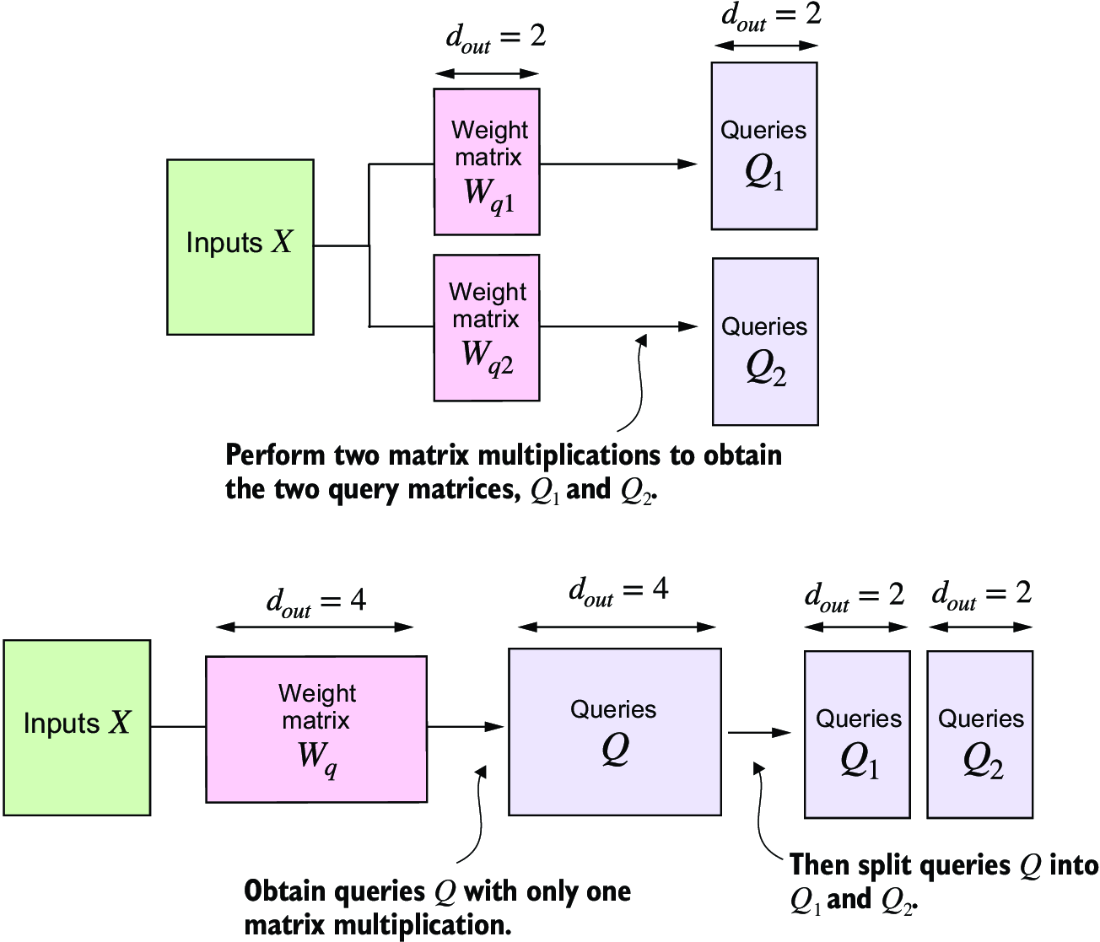

> In the MultiHeadAttentionWrapper class with two attention heads, we initialized two weight matrices, Wq1 and Wq2, and computed two query matrices, Q1 and Q2 (top). In the MultiheadAttention class, we initialize one larger weight matrix Wq, only perform one matrix multiplication with the inputs to obtain a query matrix Q, and then split the query matrix into Q1 and Q2 (bottom). We do the same for the keys and values, which are not shown to reduce visual clutter.


The splitting of the query, key, and value tensors is achieved through tensor reshaping and transposing operations using PyTorch’s .view and .transpose methods. The input is first transformed (via linear layers for queries, keys, and values) and then reshaped to represent multiple heads.

The key operation is to split the d_out dimension into num_heads and head_dim, where head_dim = d_out / num_heads. This splitting is then achieved using the .view method: a tensor of dimensions (b, num_tokens, d_out) is reshaped to dimension (b, num_tokens, num_heads, head_dim).

The tensors are then transposed to bring the num_heads dimension before the num_ tokens dimension, resulting in a shape of (b, num_heads, num_tokens, head_dim). This transposition is crucial for correctly aligning the queries, keys, and values across the different heads and performing batched matrix multiplications efficiently.

In [59]:
#1 The shape of this tensor is (b, num_heads, num_tokens, head_dim) = (1, 2, 3, 4).

a = torch.tensor([[[[0.2745, 0.6584, 0.2775, 0.8573],    #1
                    [0.8993, 0.0390, 0.9268, 0.7388],
                    [0.7179, 0.7058, 0.9156, 0.4340]],

                   [[0.0772, 0.3565, 0.1479, 0.5331],
                    [0.4066, 0.2318, 0.4545, 0.9737],
                    [0.4606, 0.5159, 0.4220, 0.5786]]]])

In [60]:
print(a @ a.transpose(2, 3))


tensor([[[[1.3208, 1.1631, 1.2879],
          [1.1631, 2.2150, 1.8424],
          [1.2879, 1.8424, 2.0402]],

         [[0.4391, 0.7003, 0.5903],
          [0.7003, 1.3737, 1.0620],
          [0.5903, 1.0620, 0.9912]]]])


In this case, the matrix multiplication implementation in PyTorch handles the four-dimensional input tensor so that the matrix multiplication is carried out between the <font color='red'>two last dimensions (num_tokens, head_dim) and then repeated for the individual heads.</font>

In [61]:
first_head = a[0, 0, :, :]
first_res = first_head @ first_head.T
print("First head:\n", first_res)

second_head = a[0, 1, :, :]
second_res = second_head @ second_head.T
print("\nSecond head:\n", second_res)

First head:
 tensor([[1.3208, 1.1631, 1.2879],
        [1.1631, 2.2150, 1.8424],
        [1.2879, 1.8424, 2.0402]])

Second head:
 tensor([[0.4391, 0.7003, 0.5903],
        [0.7003, 1.3737, 1.0620],
        [0.5903, 1.0620, 0.9912]])


In [62]:
torch.manual_seed(123)
batch_size, context_length, d_in = batch.shape
d_out = 2
mha = MultiHeadAttention(d_in, d_out, context_length, 0.0, num_heads=2)
context_vecs = mha(batch)
print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

RuntimeError: shape '[2, 6, 2, 2]' is invalid for input of size 24